In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/financial-transactions-data/Synthetic_Financial_datasets_log.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

In [3]:
file_path = "/kaggle/input/financial-transactions-data/Synthetic_Financial_datasets_log.csv"
df = pd.read_csv(file_path)

In [4]:
print("Dataset Shape:", df.shape)

Dataset Shape: (6362620, 11)


In [5]:
print("\nColumn Names and Data Types:\n", df.dtypes)


Column Names and Data Types:
 step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [6]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


1. Check for Null values in dataset

In [7]:
missing_values = df.isnull().sum()
print("\nMissing Values in Each Column:\n", missing_values)
print("\nNote: as it is a synthetic data there are not null values in databse")


Missing Values in Each Column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Note: as it is a synthetic data there are not null values in databse


2. Check for types of transactions.

In [8]:
print("\nUnique Values in 'type' column:\n", df['type'].unique())


Unique Values in 'type' column:
 ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']


3. Checking wich type has more frauds.

In [9]:
total_transactions_by_type = df['type'].value_counts()

fraud_transactions_by_type = df[df['isFraud'] == 1]['type'].value_counts()

flagged_transactions_by_type = df[df['isFlaggedFraud'] == 1]['type'].value_counts()

fraud_summary = pd.DataFrame({
    'Total Transactions': total_transactions_by_type,
    'Fraudulent Transactions': fraud_transactions_by_type,
    'Potential Fraud (isFlaggedFraud)': flagged_transactions_by_type
}).fillna(0)

fraud_summary['Fraudulent Transactions'] = fraud_summary['Fraudulent Transactions'].astype(int)
fraud_summary['Potential Fraud (isFlaggedFraud)'] = fraud_summary['Potential Fraud (isFlaggedFraud)'].astype(int)

print(fraud_summary)


          Total Transactions  Fraudulent Transactions  \
type                                                    
CASH_IN              1399284                        0   
CASH_OUT             2237500                     4116   
DEBIT                  41432                        0   
PAYMENT              2151495                        0   
TRANSFER              532909                     4097   

          Potential Fraud (isFlaggedFraud)  
type                                        
CASH_IN                                  0  
CASH_OUT                                 0  
DEBIT                                    0  
PAYMENT                                  0  
TRANSFER                                16  


4. Checking if Data Imbalance present in dataset.

In [10]:
print("\nDistribution of 'isFraud' Column:\n", df['isFraud'].value_counts())
print("\nDistribution of 'isFlaggedFraud' Column:\n", df['isFlaggedFraud'].value_counts())


Distribution of 'isFraud' Column:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64

Distribution of 'isFlaggedFraud' Column:
 isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64


Note: Here we have data imbalance because of non-fraud transactions are more in comparision with fraud transactions.

5. Making Categories amout wise to see which amount reange has more frauds.

/tmp/ipykernel_23/1541298191.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_amount_category = df.groupby('amountCategory')['isFraud'].mean().reset_index()
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


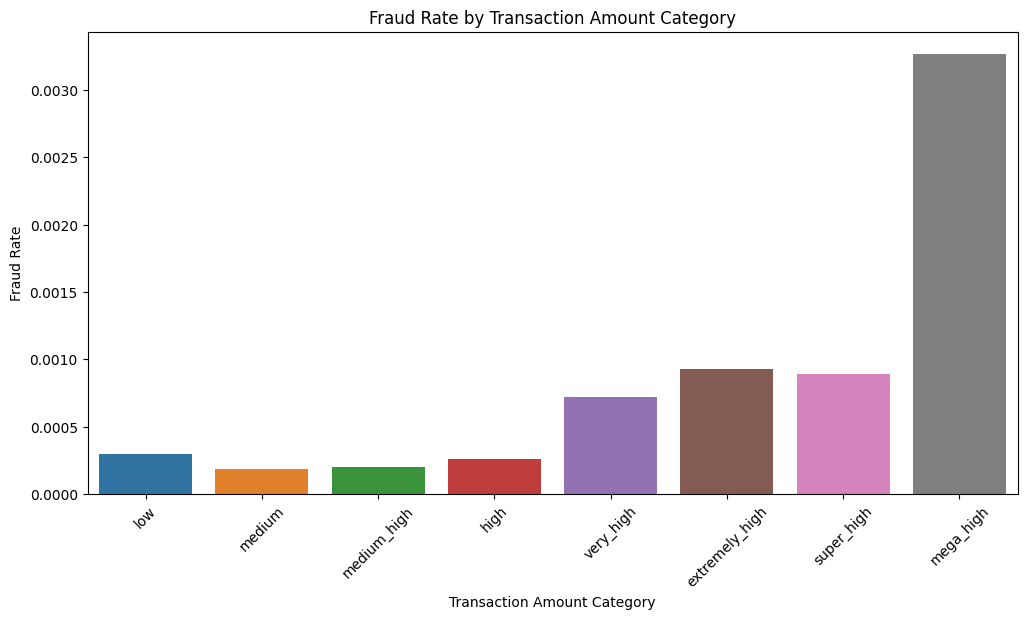

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amountCategory
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,medium_high
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,medium
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,low
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,low
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,high


In [11]:
bins = [0, 1000, 5000, 10000, 20000, 50000, 100000, 200000, float('inf')]
labels = ['low', 'medium', 'medium_high', 'high', 'very_high', 'extremely_high', 'super_high', 'mega_high']

df['amountCategory'] = pd.cut(df['amount'], bins=bins, labels=labels)

fraud_rate_by_amount_category = df.groupby('amountCategory')['isFraud'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='amountCategory', y='isFraud', data=fraud_rate_by_amount_category)
plt.title('Fraud Rate by Transaction Amount Category')
plt.xlabel('Transaction Amount Category')
plt.ylabel('Fraud Rate')
plt.xticks(rotation=45)
plt.show()

df.head()

In [12]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amountCategory
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,medium_high
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,medium
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,low
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,low
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,high
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0,mega_high
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0,mega_high
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0,mega_high
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0,mega_high


In [13]:
df.to_csv('updated_dataset.csv')

In [14]:
# Load dataset
df = pd.read_csv('/kaggle/working/updated_dataset.csv')

In [15]:
df.columns

Index(['Unnamed: 0', 'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg',
       'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
       'isFraud', 'isFlaggedFraud', 'amountCategory'],
      dtype='object')

7. Handling data imabalance by oversampling fraud transaction.

In [16]:
df.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud', 'nameOrig', 'nameDest', 'Unnamed: 0'], axis=1, inplace=True)

encoder = OneHotEncoder(drop='first')
encoded_cols = encoder.fit_transform(df[['type', 'amountCategory']]).toarray()
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out())

df = pd.concat([df.drop(['type', 'amountCategory'], axis=1), encoded_df], axis=1)

X = df.drop('isFraud', axis=1)
y = df['isFraud']

smote = SMOTE(sampling_strategy='minority')
X_res, y_res = smote.fit_resample(X, y)

Data Preparation for model training.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res)

**Note:** As our data has data imabalce so we need to choose algorithms that can handle data imabalce while training phase using various methods like providing mode weight to minority class data.

I. Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)
y_pred_prob_lr = logreg.predict_proba(X_test)[:, 1]

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print(f"Logistic Regression AUC-ROC: {roc_auc_score(y_test, y_pred_prob_lr)}")

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.69      0.49      0.57   1270881
           1       0.60      0.78      0.68   1270882

    accuracy                           0.63   2541763
   macro avg       0.64      0.63      0.62   2541763
weighted avg       0.64      0.63      0.62   2541763

Logistic Regression AUC-ROC: 0.734089352110777


II. Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_prob_rf = rf.predict_proba(X_test)[:, 1]

print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest AUC-ROC: {roc_auc_score(y_test, y_pred_prob_rf)}")

Random Forest Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98   1270881
           1       0.97      0.98      0.98   1270882

    accuracy                           0.98   2541763
   macro avg       0.98      0.98      0.98   2541763
weighted avg       0.98      0.98      0.98   2541763

Random Forest AUC-ROC: 0.9978932847572708


III. XGBoost Classifer

In [20]:
from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_pred_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost AUC-ROC: {roc_auc_score(y_test, y_pred_prob_xgb)}")

XGBoost Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95   1270881
           1       0.96      0.93      0.95   1270882

    accuracy                           0.95   2541763
   macro avg       0.95      0.95      0.95   2541763
weighted avg       0.95      0.95      0.95   2541763

XGBoost AUC-ROC: 0.9903012271150295


In [21]:
from sklearn.metrics import f1_score, roc_auc_score

results = {
    'Model': ['Random Forest', 'XGBoost', 'Logistic Regression'],
    'AUC-ROC': [roc_auc_score(y_test, y_pred_prob_rf),
                roc_auc_score(y_test, y_pred_prob_xgb),
                roc_auc_score(y_test, y_pred_prob_lr)],
    'F1-Score': [f1_score(y_test, y_pred_rf),
                 f1_score(y_test, y_pred_xgb),
                 f1_score(y_test, y_pred_lr)]
}

results_df = pd.DataFrame(results)
print(results_df)


                 Model   AUC-ROC  F1-Score
0        Random Forest  0.997893  0.977705
1              XGBoost  0.990301  0.947155
2  Logistic Regression  0.734089  0.678674


**Conclusion:** By comparing performance of all three model, it shows that Logistc Regression's performance is lower than other 2 models. on other hand, Random forest's accuracy is 100% which tends to be overfitting. That's why I am choosing XGBoost as a final detection model for our usecase.

In [22]:
import joblib

joblib.dump(xgb, 'xgboost_fraud_model.pkl')

print("XGBoost model saved!")

XGBoost model saved!
